In [1]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np

%config InlineBackend.figure_format = 'retina'
from datetime import datetime

# Data Reading

## Turin Real Data
Real Turin Data is extracted from: [https://covid19.infn.it/iss/](https://covid19.infn.it/iss/)


In [2]:
turin_real_deaths = pd.read_csv('../data/turin-real/iss_bydate_torino_deceduti.csv', delimiter=',')
turin_real_positives = pd.read_csv('../data/turin-real/iss_bydate_torino_positivi.csv', delimiter=',')
turin_real_recoveries = pd.read_csv('../data/turin-real/iss_bydate_torino_ricoveri.csv', delimiter=',')
turin_real_icu = pd.read_csv('../data/turin-real/iss_bydate_torino_terapia_intensiva.csv', delimiter=',')
turin_real_symptomatic_age_wide = pd.read_csv('../data/turin-real/iss_age_date_piemonte_sintomatici.csv', delimiter=',')
turin_real_positives_age_wide = pd.read_csv('../data/turin-real/iss_age_date_piemonte_positivi.csv', delimiter=',')
turin_real_deaths_age_wide = pd.read_csv('../data/turin-real/iss_age_date_piemonte_deceduti.csv', delimiter=',')

In [3]:
turin_real_deaths_age_wide

,data,0-5 anni,6-12 anni,13-19 anni,20-29 anni,30-39 anni,40-49 anni,50-59 anni,60-69 anni,70-79 anni,80-89 anni,≥90 anni
0,2020-02-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-02-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.285714,0.0
4,2020-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.428571,0.142857,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1199,2023-06-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
1200,2023-06-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.142857,0.0
1201,2023-06-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1202,2023-06-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
def join_based_on_min_date(df1, df2):
    min_date = min(df1['date'].min(), df2['date'].min())
    if min_date == df1['date'].min():
        left_df = df1
        right_df = df2
    else:
        left_df = df2
        right_df = df1

    merged = pd.merge(left_df, right_df, on='date', how='left')
    return merged.filter(regex=r'^(?!.*casi).*$', axis=1)

def process_age_separation(df, variableName):
    result = pd.DataFrame(columns=['date', variableName+'-Student', variableName+'-Worker', variableName+'-Retired'])
    result['date'] = df['data']
    result[variableName+'-Student'] = df['0-5 anni'] + df['6-12 anni'] + df['13-19 anni'] + df['20-29 anni']
    result[variableName+'-Worker'] = df['30-39 anni'] + df['40-49 anni'] + df['50-59 anni']
    result[variableName+'-Retired'] = df['60-69 anni'] + df['70-79 anni'] + df['80-89 anni'] + df['≥90 anni']

    return result



turin_real_deaths.columns = ['date','casi','deaths_7_days']
turin_real_positives.columns = ['date','casi','positives_7_days']
turin_real_recoveries.columns = ['date','casi','recoveries_7_days']
turin_real_icu.columns = ['date','casi','icu_7_days']

turin_real_symptomatic_age = process_age_separation(turin_real_symptomatic_age_wide,'symptomatic')
turin_real_positives_age = process_age_separation(turin_real_positives_age_wide,'positives')
turin_real_deaths_age = process_age_separation(turin_real_deaths_age_wide,'deaths')

turin_real = join_based_on_min_date(turin_real_deaths,turin_real_positives)
turin_real = join_based_on_min_date(turin_real,turin_real_recoveries)
turin_real = join_based_on_min_date(turin_real,turin_real_icu)
turin_real = join_based_on_min_date(turin_real,turin_real_symptomatic_age)
turin_real = join_based_on_min_date(turin_real,turin_real_positives_age)
turin_real = join_based_on_min_date(turin_real,turin_real_deaths_age)
turin_real



,date,symptomatic-Student,symptomatic-Worker,symptomatic-Retired,positives_7_days,deaths_7_days,recoveries_7_days,icu_7_days,positives-Student,positives-Worker,positives-Retired,deaths-Student,deaths-Worker,deaths-Retired
0,2020-01-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-31,0.142857,1.714286,0.285714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-02-01,0.142857,1.571429,0.285714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1189,2023-05-01,0.285714,0.714286,1.571429,100.285714,0.285714,3.714286,NaN,17.571429,63.285714,89.000000,0.0,0.0,0.285714
1190,2023-05-02,0.142857,0.571429,1.142857,97.000000,0.142857,3.285714,NaN,16.142857,60.000000,88.428571,0.0,0.0,0.142857
1191,2023-05-03,NaN,NaN,NaN,93.000000,0.285714,3.428571,NaN,16.285714,58.000000,84.714286,0.0,0.0,0.285714
1192,2023-05-04,NaN,NaN,NaN,90.285714,0.285714,3.428571,NaN,15.285714,58.142857,82.714286,0.0,0.0,0.428571


### Data Adjustment For Population

Dati estratti da: [http://dati.istat.it/Index.aspx?QueryId=18540](http://dati.istat.it/Index.aspx?QueryId=18540)


In [5]:
## Adjust data based on Turin Polulation
population_df = pd.DataFrame(columns=['Year','Region','Province','City'])

population_df.loc[len(population_df)] = [2020, 4311217,2230946,857910]
population_df.loc[len(population_df)] = [2021, 4274945,2219206,858205]
population_df.loc[len(population_df)] = [2022, 4256350,2208370,848748]
population_df.loc[len(population_df)] = [2023, 4240736,2198237,841600]

population_df

,Year,Region,Province,City
0,2020,4311217,2230946,857910
1,2021,4274945,2219206,858205
2,2022,4256350,2208370,848748
3,2023,4240736,2198237,841600


In [6]:
turin_real_data_origin = {
    'deaths_7_days':'province',
    'positives_7_days':'province',
    'recoveries_7_days':'province',
    'icu_7_days':'province',
    'symptomatic-Student':'region',
    'symptomatic-Worker':'region',
    'symptomatic-Retired':'region',
    'positives-Student':'region',
    'positives-Worker':'region',
    'positives-Retired':'region',
    'deaths-Student':'region',
    'deaths-Worker':'region',
    'deaths-Retired':'region'
}

turin_real_data_origin

{'deaths_7_days': 'province',
 'positives_7_days': 'province',
 'recoveries_7_days': 'province',
 'icu_7_days': 'province',
 'symptomatic-Student': 'region',
 'symptomatic-Worker': 'region',
 'symptomatic-Retired': 'region',
 'positives-Student': 'region',
 'positives-Worker': 'region',
 'positives-Retired': 'region',
 'deaths-Student': 'region',
 'deaths-Worker': 'region',
 'deaths-Retired': 'region'}

In [7]:
def get_multiplier(variable_name, year):
    year_data = population_df[population_df['Year'] == year]
    data_from = turin_real_data_origin[variable_name]
    multiplier = 1
    if data_from == 'region':
        multiplier = year_data['City'] / year_data['Region']

    if data_from == 'province':
        multiplier = year_data['City'] / year_data['Province']

    if data_from == 'city':
        multiplier = 1

    return multiplier

def adjust_value_for_year_population(row):
    year = int(row['date'][:4])  # Extract the year from the 'date' column as an integer

    result_dictionary = {}
    for column_name, value in row.items():
        if column_name == 'date':
            result_dictionary[column_name] = value
            continue
        multiplier = get_multiplier(column_name, year)
        result_dictionary[column_name] = row[column_name] * multiplier
        #row[column_name] *= multiplier

    return pd.Series(result_dictionary)



turin_real_adjusted = turin_real.copy()
turin_real_adjusted = turin_real_adjusted.apply(adjust_value_for_year_population ,axis=1)

for columnName in turin_real_adjusted.columns:
    if columnName == 'date':
        continue
    turin_real_adjusted[columnName] = turin_real_adjusted[columnName].astype(turin_real.dtypes[columnName])

turin_real_adjusted


C:\Users\Utente\AppData\Local\Temp\ipykernel_12312\958216839.py:38: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  turin_real_adjusted[columnName] = turin_real_adjusted[columnName].astype(turin_real.dtypes[columnName])
C:\Users\Utente\AppData\Local\Temp\ipykernel_12312\958216839.py:38: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  turin_real_adjusted[columnName] = turin_real_adjusted[columnName].astype(turin_real.dtypes[columnName])
C:\Users\Utente\AppData\Local\Temp\ipykernel_12312\958216839.py:38: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  turin_real_adjusted[columnName] = turin_real_adjusted[columnName].astype(turin_real.dtypes[columnName])
C:\Users\Utente\AppData\Local\Temp\ipykernel_1231

,date,symptomatic-Student,symptomatic-Worker,symptomatic-Retired,positives_7_days,deaths_7_days,recoveries_7_days,icu_7_days,positives-Student,positives-Worker,positives-Retired,deaths-Student,deaths-Worker,deaths-Retired
0,2020-01-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-31,0.028428,0.341134,0.056856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-02-01,0.028428,0.312706,0.056856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1189,2023-05-01,0.056702,0.141754,0.311860,38.394612,0.109386,1.422023,NaN,3.487157,12.559437,17.662594,0.0,0.0,0.056702
1190,2023-05-02,0.028351,0.113403,0.226807,37.136669,0.054693,1.257943,NaN,3.203649,11.907367,17.549191,0.0,0.0,0.028351
1191,2023-05-03,NaN,NaN,NaN,35.605260,0.109386,1.312636,NaN,3.232000,11.510455,16.812068,0.0,0.0,0.056702
1192,2023-05-04,NaN,NaN,NaN,34.566090,0.109386,1.312636,NaN,3.033544,11.538806,16.415156,0.0,0.0,0.085053


### Check Data

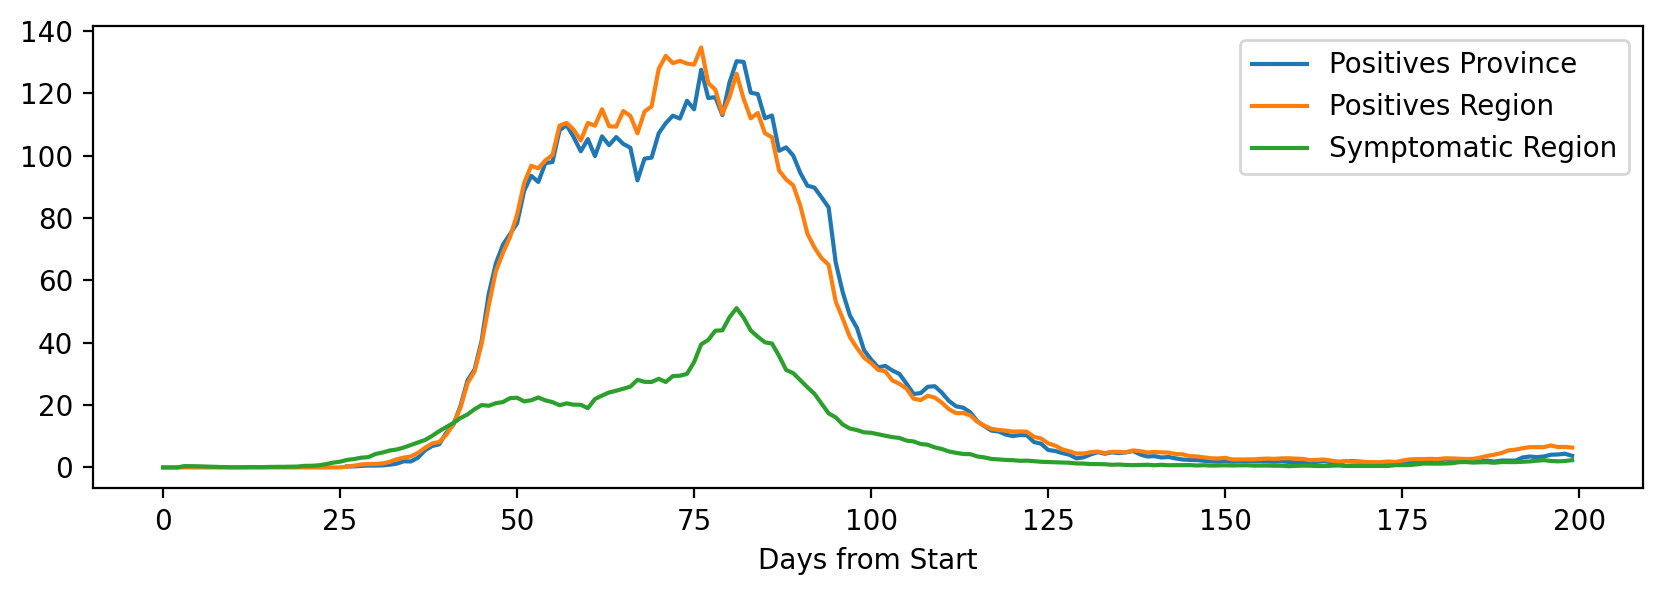

In [8]:
days = 200
fig,axes = plt.subplots(figsize=(10, 3))

axes.plot(turin_real_adjusted.loc[:days-1,'positives_7_days'], label='Positives Province')

by_age_positives = turin_real_adjusted[['positives-Student','positives-Worker','positives-Retired']].iloc[:days].sum(axis=1)
axes.plot(by_age_positives, label='Positives Region')

by_age_symptomatic = turin_real_adjusted[['symptomatic-Student','symptomatic-Worker','symptomatic-Retired']].iloc[:days].sum(axis=1)
axes.plot(by_age_symptomatic, label='Symptomatic Region')

# Add plot labels and legend
plt.xlabel('Days from Start')
plt.legend()


#plt.tight_layout()
# Show the plot
plt.show()

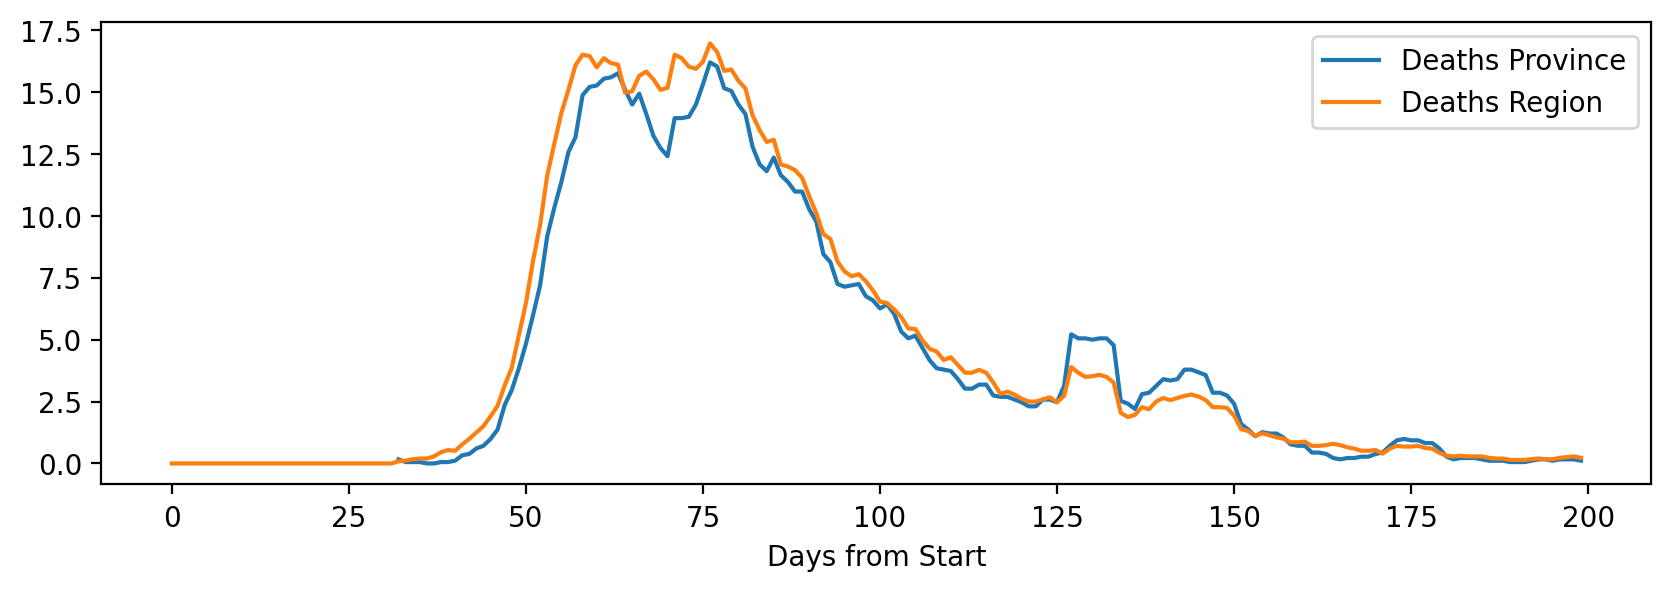

In [9]:
days = 200
fig,axes = plt.subplots(figsize=(10, 3))

axes.plot(turin_real_adjusted.loc[:days-1,'deaths_7_days'], label='Deaths Province')

by_age_positives = turin_real_adjusted[['deaths-Student','deaths-Worker','deaths-Retired']].iloc[:days].sum(axis=1)
axes.plot(by_age_positives, label='Deaths Region')

# Add plot labels and legend
plt.xlabel('Days from Start')
plt.legend()


#plt.tight_layout()
# Show the plot
plt.show()

In [10]:
turin_real_adjusted

,date,symptomatic-Student,symptomatic-Worker,symptomatic-Retired,positives_7_days,deaths_7_days,recoveries_7_days,icu_7_days,positives-Student,positives-Worker,positives-Retired,deaths-Student,deaths-Worker,deaths-Retired
0,2020-01-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-31,0.028428,0.341134,0.056856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-02-01,0.028428,0.312706,0.056856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1189,2023-05-01,0.056702,0.141754,0.311860,38.394612,0.109386,1.422023,NaN,3.487157,12.559437,17.662594,0.0,0.0,0.056702
1190,2023-05-02,0.028351,0.113403,0.226807,37.136669,0.054693,1.257943,NaN,3.203649,11.907367,17.549191,0.0,0.0,0.028351
1191,2023-05-03,NaN,NaN,NaN,35.605260,0.109386,1.312636,NaN,3.232000,11.510455,16.812068,0.0,0.0,0.056702
1192,2023-05-04,NaN,NaN,NaN,34.566090,0.109386,1.312636,NaN,3.033544,11.538806,16.415156,0.0,0.0,0.085053


## Simulations
For simulations we read all the simulation files in a specific folder and store them in a dictionary with their simulation ID

In [11]:
simulations_logs_dir = '../data/simulations'
simulations_logs_df = {}

for sim_log_file_name in os.listdir(simulations_logs_dir):
    file_path = os.path.join(simulations_logs_dir, sim_log_file_name)
    sim_number = int(re.findall(r'\d+', sim_log_file_name)[0])

    log_df = pd.read_csv(file_path, delimiter=';')
    simulations_logs_df[sim_number] = log_df



## GHETTO FIX FOR ERROR IN LOG FILES
for simulation_index in simulations_logs_df.keys():
    if simulation_index < 34:
        continue

    shifted_df = simulations_logs_df[simulation_index].shift(periods=1, axis=1)
    # Set the new index (in this example, just using default index values)
    shifted_df.index = range(len(shifted_df))
    simulations_logs_df[simulation_index] = shifted_df

# Data Loading
The following code snippets are for loading the read data into a defined scheme (with matching names) for both the real and the similations

The overall structure should be the following:

- Date
- DeathsByDay TotalDeaths
- PositivesByDay TotalPositives

In [12]:
shared_column_names = ['Date',
                       'DeathsStudentByDay','DeathsWorkerByDay','DeathsRetiredByDay','DeathsByDay', 'DeathsTotal',
                       'AsymptomaticStudentByDay','AsymptomaticWorkerByDay','AsymptomaticRetiredByDay','AsymptomaticAllByDay', 'AsymptomaticTotal',
                       'SymptomaticStudentByDay','SymptomaticWorkerByDay','SymptomaticRetiredByDay','SymptomaticByDay', 'SymptomaticTotal',
                       'PositivesStudentByDay','PositivesWorkerByDay','PositivesRetiredByDay','PositivesByDay', 'PositivesTotal',
                       'DeathToPositivesRatioStudent','DeathToPositivesRatioWorker','DeathToPositivesRatioRetired','DeathToPositivesRatio']

use_moving_average = True

## Turin Real

In [13]:
turin_real_adjusted.columns

Index(['date', 'symptomatic-Student', 'symptomatic-Worker',
       'symptomatic-Retired', 'positives_7_days', 'deaths_7_days',
       'recoveries_7_days', 'icu_7_days', 'positives-Student',
       'positives-Worker', 'positives-Retired', 'deaths-Student',
       'deaths-Worker', 'deaths-Retired'],
      dtype='object')

In [14]:
turin_data = pd.DataFrame(columns=shared_column_names)

turin_data['Date'] = pd.date_range(start=turin_real_adjusted['date'][0], periods=len(turin_real))

turin_data['DeathsStudentByDay'] = turin_real_adjusted['deaths-Student']
turin_data['DeathsWorkerByDay'] = turin_real_adjusted['deaths-Worker']
turin_data['DeathsRetiredByDay'] = turin_real_adjusted['deaths-Retired'];
turin_data['DeathsByDay'] = turin_data[['DeathsStudentByDay','DeathsWorkerByDay','DeathsRetiredByDay']].sum(axis=1)
turin_data['DeathsTotal'] = turin_data['DeathsByDay'].cumsum()

turin_data['PositivesStudentByDay'] = turin_real_adjusted['positives-Student']
turin_data['PositivesWorkerByDay'] = turin_real_adjusted['positives-Worker']
turin_data['PositivesRetiredByDay'] = turin_real_adjusted['positives-Retired'];
turin_data['PositivesByDay'] = turin_data[['PositivesStudentByDay','PositivesWorkerByDay','PositivesRetiredByDay']].sum(axis=1)
turin_data['PositivesTotal'] = turin_data['PositivesByDay'].cumsum()

turin_data['SymptomaticStudentByDay'] = turin_real_adjusted['symptomatic-Student']
turin_data['SymptomaticWorkerByDay'] = turin_real_adjusted['symptomatic-Worker']
turin_data['SymptomaticRetiredByDay'] = turin_real_adjusted['symptomatic-Retired'];
turin_data['SymptomaticByDay'] = turin_data[['SymptomaticStudentByDay','SymptomaticWorkerByDay','SymptomaticRetiredByDay']].sum(axis=1)
turin_data['SymptomaticTotal'] = turin_data['SymptomaticByDay'].cumsum()

turin_data['AsymptomaticByDay'] = np.nan
turin_data['AsymptomaticTotal'] = turin_data['AsymptomaticByDay'].cumsum()


turin_data['DeathToPositivesRatio'] = turin_data['DeathsTotal'] / turin_data['PositivesTotal']

turin_data

,Date,DeathsStudentByDay,DeathsWorkerByDay,DeathsRetiredByDay,DeathsByDay,DeathsTotal,AsymptomaticStudentByDay,AsymptomaticWorkerByDay,AsymptomaticRetiredByDay,AsymptomaticAllByDay,...,PositivesStudentByDay,PositivesWorkerByDay,PositivesRetiredByDay,PositivesByDay,PositivesTotal,DeathToPositivesRatioStudent,DeathToPositivesRatioWorker,DeathToPositivesRatioRetired,DeathToPositivesRatio,AsymptomaticByDay
0,2020-01-28,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
1,2020-01-29,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
2,2020-01-30,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
3,2020-01-31,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
4,2020-02-01,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1189,2023-05-01,0.0,0.0,0.056702,0.056702,2904.838067,NaN,NaN,NaN,NaN,...,3.487157,12.559437,17.662594,33.709189,343129.441203,NaN,NaN,NaN,0.008466,NaN
1190,2023-05-02,0.0,0.0,0.028351,0.028351,2904.866418,NaN,NaN,NaN,NaN,...,3.203649,11.907367,17.549191,32.660207,343162.101409,NaN,NaN,NaN,0.008465,NaN
1191,2023-05-03,0.0,0.0,0.056702,0.056702,2904.923120,NaN,NaN,NaN,NaN,...,3.232000,11.510455,16.812068,31.554523,343193.655932,NaN,NaN,NaN,0.008464,NaN
1192,2023-05-04,0.0,0.0,0.085053,0.085053,2905.008172,NaN,NaN,NaN,NaN,...,3.033544,11.538806,16.415156,30.987505,343224.643437,NaN,NaN,NaN,0.008464,NaN


## Simulations

In [15]:
sim_start_date = pd.to_datetime('2020-02-20')
sim_start_date

Timestamp('2020-02-20 00:00:00')

In [16]:
def load_one_simulation(simulation_df):
    sim = pd.DataFrame(columns=shared_column_names)

    sim['DeathsByDay'] = simulation_df['Death'].diff()
    sim['DeathsTotal'] = simulation_df['Death']

    sim['SymptomaticByDay'] = simulation_df['SymptomaticNew']
    sim['SymptomaticTotal'] = sim['SymptomaticByDay'].cumsum()

    sim['AsymptomaticByDay'] = simulation_df['AsymptomaticNew']
    sim['AsymptomaticTotal'] = sim['AsymptomaticByDay'].cumsum()

    sim['PositivesByDay'] = sim['SymptomaticByDay'] + sim['AsymptomaticByDay']
    sim['PositivesTotal'] = sim['PositivesByDay'].cumsum()

    sim['DeathToPositivesRatio'] = sim['DeathsTotal'] / sim['PositivesTotal']

    sim['Date'] = pd.date_range(start=sim_start_date, periods=len(simulation_df))

    return sim


first_key, first_value = next(iter(simulations_logs_df.items()))
simulation_example = load_one_simulation(first_value)
simulation_example

,Date,DeathsStudentByDay,DeathsWorkerByDay,DeathsRetiredByDay,DeathsByDay,DeathsTotal,AsymptomaticStudentByDay,AsymptomaticWorkerByDay,AsymptomaticRetiredByDay,AsymptomaticAllByDay,...,PositivesStudentByDay,PositivesWorkerByDay,PositivesRetiredByDay,PositivesByDay,PositivesTotal,DeathToPositivesRatioStudent,DeathToPositivesRatioWorker,DeathToPositivesRatioRetired,DeathToPositivesRatio,AsymptomaticByDay
0,2020-02-20,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,35,35,NaN,NaN,NaN,0.000000,10
1,2020-02-21,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,35,NaN,NaN,NaN,0.000000,0
2,2020-02-22,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3,38,NaN,NaN,NaN,0.000000,0
3,2020-02-23,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,48,86,NaN,NaN,NaN,0.000000,27
4,2020-02-24,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,130,216,NaN,NaN,NaN,0.000000,76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,2021-04-02,NaN,NaN,NaN,5.0,6796,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,61,61848,NaN,NaN,NaN,0.109882,34
408,2021-04-03,NaN,NaN,NaN,3.0,6799,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,65,61913,NaN,NaN,NaN,0.109815,40
409,2021-04-04,NaN,NaN,NaN,6.0,6805,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,55,61968,NaN,NaN,NaN,0.109815,32
410,2021-04-05,NaN,NaN,NaN,1.0,6806,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,67,62035,NaN,NaN,NaN,0.109712,41


In [17]:
sims_data = {}
for sim_number, sim_original_df in simulations_logs_df.items():
    sims_data[sim_number] = load_one_simulation(sim_original_df)

# Comparative Analysis

In [18]:
#simulations_to_compare = [18,24,39,40]
#simulations_to_compare = [39,40]
#simulations_to_compare = [18,39]
#simulations_to_compare = [41,42,43,44]
simulations_to_compare = [41,45]

def plot_compare_real_sims(turin_data_in, sims_data_dictionary_in, column_name, simulations_to_show, start_date, end_date):

    fig,axes = plt.subplots(figsize=(10, 3))

    mask = (turin_data_in['Date'] >= start_date) & (turin_data_in['Date'] <= end_date)
    real_series = turin_data_in.loc[mask, column_name].reset_index(drop=True)
    axes.plot(real_series, label='Real')

    real_lockdown = '2020-03-11'
    real_date_series = turin_data_in.loc[mask, 'Date'].reset_index(drop=True)
    matching_rows = real_date_series[real_date_series == pd.to_datetime(real_lockdown)].index
    if not matching_rows.empty:
        axes.axvline(matching_rows[0], color='blue', linestyle='--', label='Real Lockdown')

    for idx in simulations_to_show:
        sim_df = sims_data_dictionary_in.get(idx)

        if sim_df is not None and column_name in sim_df.columns and 'Date' in sim_df.columns:
            mask = (sim_df['Date'] >= start_date) & (sim_df['Date'] <= end_date)
            series = sim_df.loc[mask, column_name].reset_index(drop=True)
            #moving average
            series = series.rolling(window=7).mean()
            axes.plot(series, label=idx)

    # Add plot labels and legend
    plt.xlabel('Days from Start')
    #plt.xticks(range(26,len(real_series), 10),rotation=45)
    plt.ylabel(column_name)
    plt.legend()


    #plt.tight_layout()
    # Show the plot
    plt.show()

## Deaths

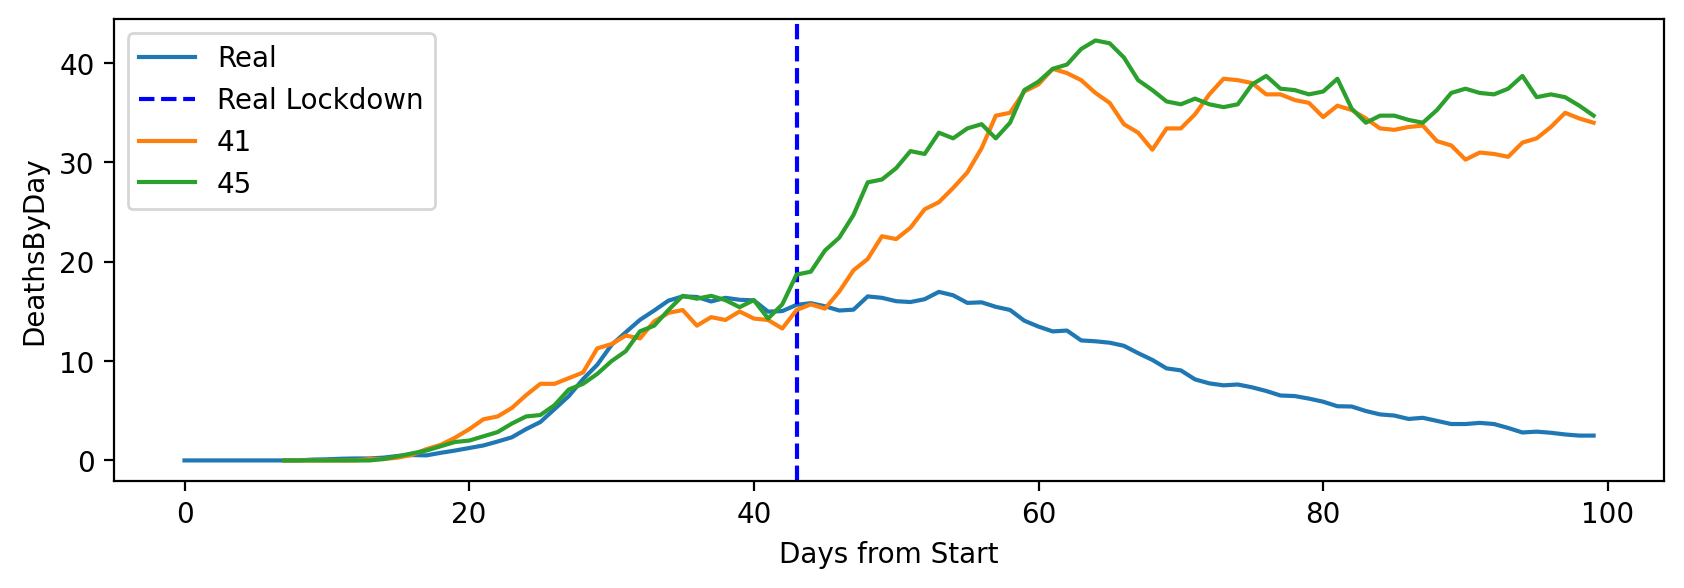

In [27]:
plotting_start_date = pd.to_datetime('2020-2-20')
plotting_end_date = pd.date_range(start=plotting_start_date, periods=100)[-1]

plot_compare_real_sims(turin_data, sims_data, 'DeathsByDay', simulations_to_compare , plotting_start_date, plotting_end_date)

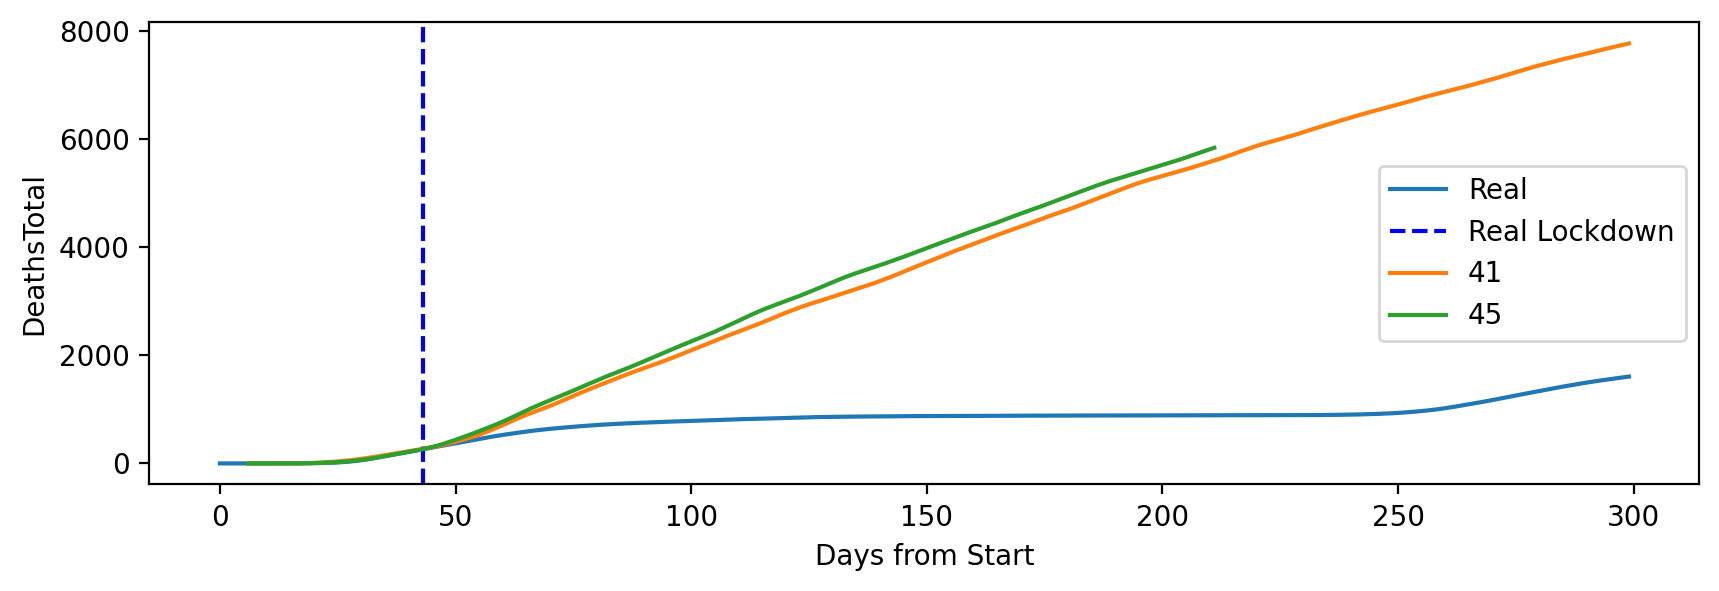

In [20]:
plot_compare_real_sims(turin_data, sims_data, 'DeathsTotal', simulations_to_compare, plotting_start_date, plotting_end_date)

## Positives

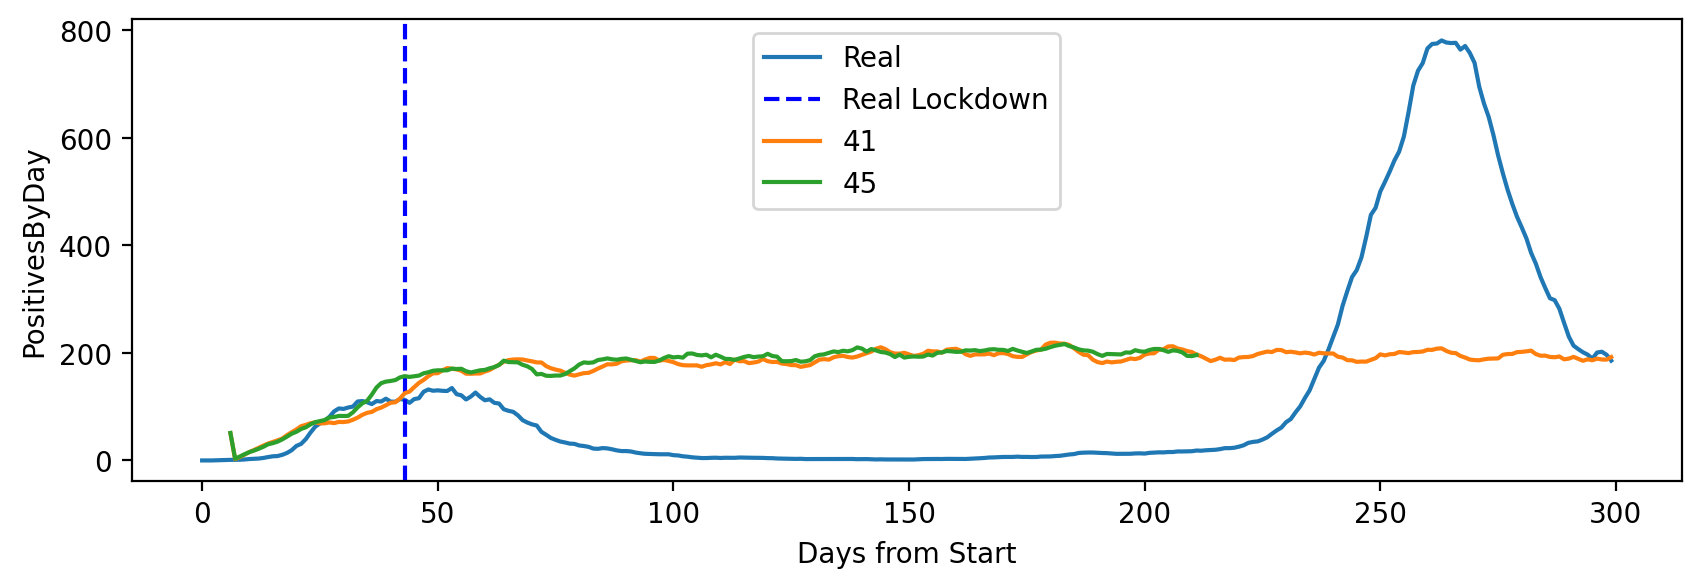

In [21]:
plot_compare_real_sims(turin_data, sims_data, 'PositivesByDay', simulations_to_compare  ,plotting_start_date, plotting_end_date)

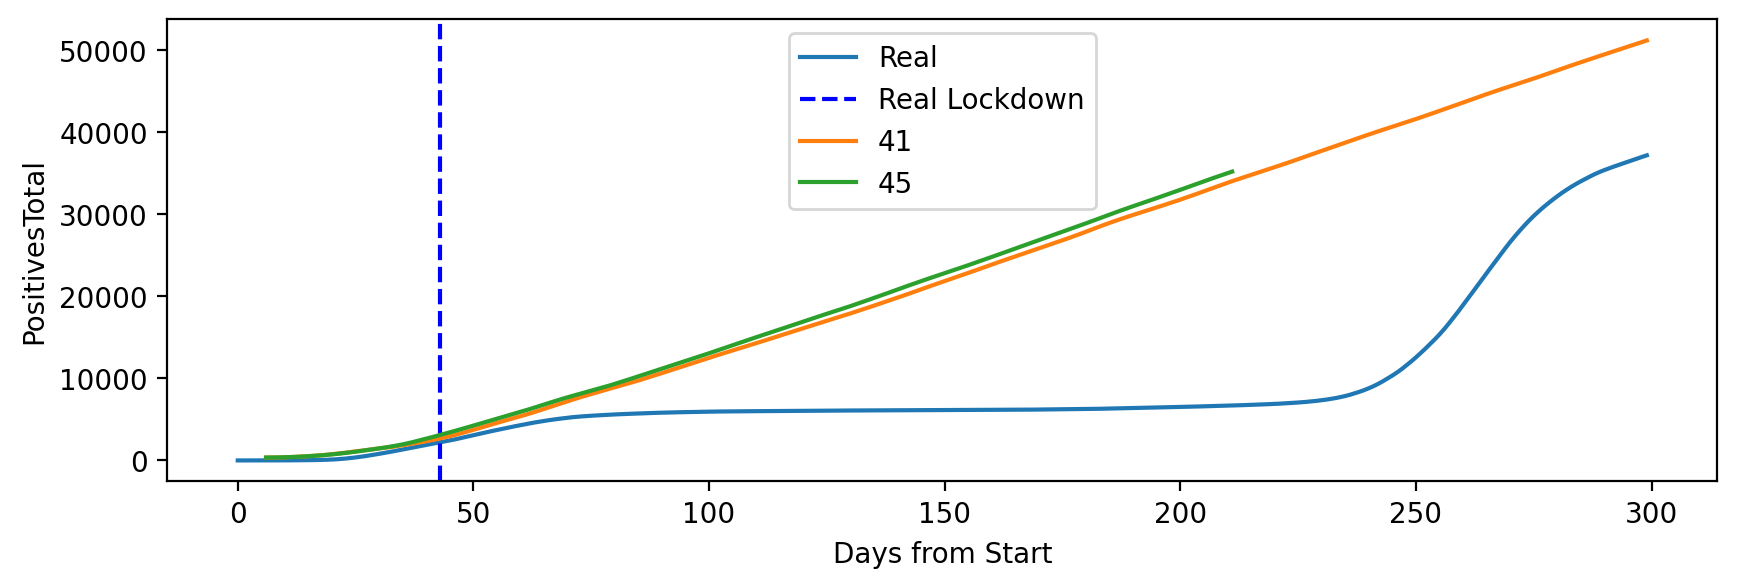

In [22]:
plot_compare_real_sims(turin_data, sims_data, 'PositivesTotal', simulations_to_compare  ,plotting_start_date, plotting_end_date)

## Death To Positive

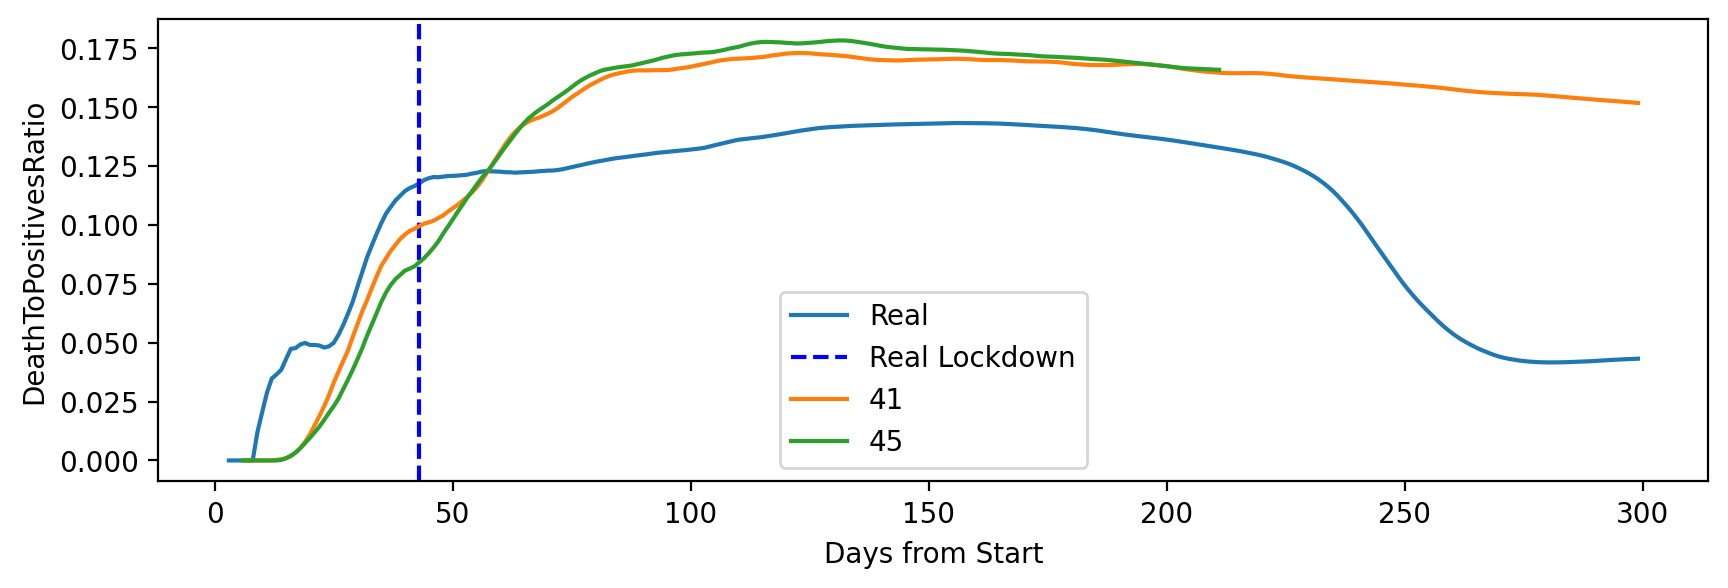

In [23]:
plot_compare_real_sims(turin_data, sims_data, 'DeathToPositivesRatio', simulations_to_compare  ,plotting_start_date, plotting_end_date)

# Simulation Analysis
Here we have an overall analysis of only data coming from the simulations

In [24]:
sims_data[39]

,Date,DeathsStudentByDay,DeathsWorkerByDay,DeathsRetiredByDay,DeathsByDay,DeathsTotal,AsymptomaticStudentByDay,AsymptomaticWorkerByDay,AsymptomaticRetiredByDay,AsymptomaticAllByDay,...,PositivesStudentByDay,PositivesWorkerByDay,PositivesRetiredByDay,PositivesByDay,PositivesTotal,DeathToPositivesRatioStudent,DeathToPositivesRatioWorker,DeathToPositivesRatioRetired,DeathToPositivesRatio,AsymptomaticByDay
0,2020-02-20,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,350,350,NaN,NaN,NaN,0.000000,250
1,2020-02-21,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,350,NaN,NaN,NaN,0.000000,0
2,2020-02-22,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,350,NaN,NaN,NaN,0.000000,0
3,2020-02-23,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,350,NaN,NaN,NaN,0.000000,0
4,2020-02-24,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1,351,NaN,NaN,NaN,0.000000,0
5,2020-02-25,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,11,362,NaN,NaN,NaN,0.000000,4
6,2020-02-26,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,25,387,NaN,NaN,NaN,0.000000,13
7,2020-02-27,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,30,417,NaN,NaN,NaN,0.000000,22
8,2020-02-28,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,41,458,NaN,NaN,NaN,0.000000,28
9,2020-02-29,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,50,508,NaN,NaN,NaN,0.000000,39


## Compare Simulation Equality

To compare simulation equality we use the root mean square error
[https://vedexcel.com/how-to-calculate-root-mean-squared-error-rmse-in-python/](https://vedexcel.com/how-to-calculate-root-mean-squared-error-rmse-in-python/)

In [25]:
def rms(series_1, series_2):
    series_1_len = len(series_1)
    series_2_len = len(series_2)
    min_len = min(series_1_len,series_2_len)

    series_1_compare = series_1[:min_len].fillna(0).tolist()
    series_2_compare = series_2[:min_len].fillna(0).tolist()
    return sqrt(mean_squared_error(series_1_compare,series_2_compare))

def simulations_rms(sim_1_number, sim_2_number, variable_name):
    variable_rms = rms(sims_data[sim_1_number][variable_name], sims_data[sim_2_number][variable_name])
    print('Simulations: ' + str(sim_1_number) + ' VS ' + str(sim_2_number) + ' -> RMS on ' + variable_name + ' is: ' + str(variable_rms))

In [26]:
simulations_rms(41,42,'DeathsByDay')
simulations_rms(41,43,'DeathsByDay')
simulations_rms(41,44,'DeathsByDay')
simulations_rms(43,44,'DeathsByDay')
simulations_rms(41,45,'DeathsByDay')

Simulations: 41 VS 42 -> RMS on DeathsByDay is: 6.763358393562812
Simulations: 41 VS 43 -> RMS on DeathsByDay is: 10.552084686357961
Simulations: 41 VS 44 -> RMS on DeathsByDay is: 9.400602296098468
Simulations: 43 VS 44 -> RMS on DeathsByDay is: 12.717580041236742
Simulations: 41 VS 45 -> RMS on DeathsByDay is: 7.697095752221608
